In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv', index_col='id')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv', index_col='id')
submission = pd.read_csv('/kaggle/input/playground-series-s4e3/sample_submission.csv', index_col='id')

pd.concat([train_data, test_data]).info()

<class 'pandas.core.frame.DataFrame'>
Index: 32033 entries, 0 to 32032
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              32033 non-null  int64  
 1   X_Maximum              32033 non-null  int64  
 2   Y_Minimum              32033 non-null  int64  
 3   Y_Maximum              32033 non-null  int64  
 4   Pixels_Areas           32033 non-null  int64  
 5   X_Perimeter            32033 non-null  int64  
 6   Y_Perimeter            32033 non-null  int64  
 7   Sum_of_Luminosity      32033 non-null  int64  
 8   Minimum_of_Luminosity  32033 non-null  int64  
 9   Maximum_of_Luminosity  32033 non-null  int64  
 10  Length_of_Conveyer     32033 non-null  int64  
 11  TypeOfSteel_A300       32033 non-null  int64  
 12  TypeOfSteel_A400       32033 non-null  int64  
 13  Steel_Plate_Thickness  32033 non-null  int64  
 14  Edges_Index            32033 non-null  float64
 15  Empty_I

* Combining the datasets, we can see there are no null values across both the training and testing data. 
* Target values are binary (0/1), and below you can see that many of these features are unbalanced.
* For some of the target values, we can observe there are no faults for certain steel plates. Plates with multiple faults will be placed into the 'Other_Faults' category and those without faults will be removed from the dataset.
* All features appear to be numerical.

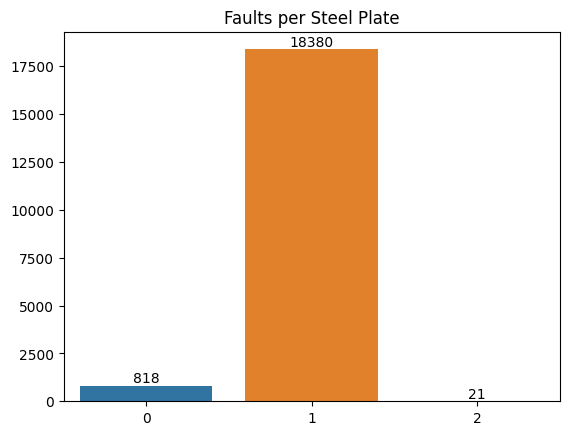

In [3]:
target_features = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
target_data = train_data[target_features]

fault_counts = np.unique(target_data.sum(axis=1), return_counts=True)
ax = sns.barplot(x=fault_counts[0], y=fault_counts[1])
ax.bar_label(ax.containers[0], fontsize=10)
plt.title("Faults per Steel Plate")
plt.show()

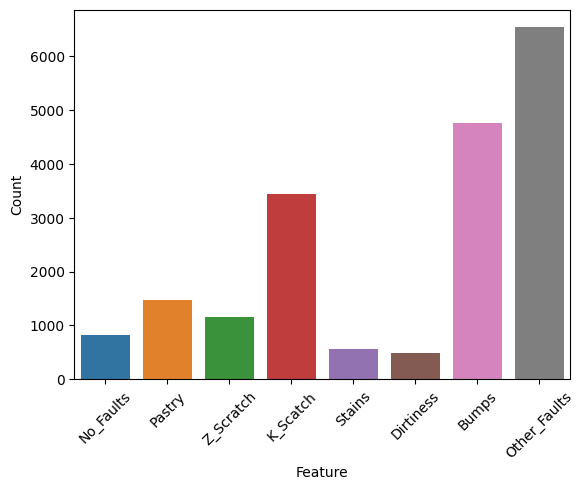

In [4]:
target = target_data@(np.arange(target_data.shape[1])+1)
target[target_data.sum(axis=1)==2] = 3

ax = sns.countplot(x=target)

tick_labels = list(target_data.columns)
tick_labels.insert(0, 'No_Faults')

ax.set(xlabel='Feature', ylabel='Count', xticklabels=tick_labels)
ax.tick_params(axis='x', rotation=45)
plt.show()

In [5]:
train_data.drop(np.where(target_data.sum(axis=1) == 0)[0], inplace=True)

In [6]:
def add_new_features(df):
    df['X_Range'] = df['X_Maximum'] - df['X_Minimum']
    df['Y_Range'] = df['Y_Maximum'] - df['Y_Minimum']
    
    df['Range_of_Luminosity'] = df['Maximum_of_Luminosity'] - df['Minimum_of_Luminosity']

    df['Total_Perimeter'] = df['X_Perimeter'] + df['Y_Perimeter']
    df['Area_Perimeter_Ratio'] = df['Pixels_Areas'] / df['Total_Perimeter']
    
    return df

In [7]:
train_data = add_new_features(train_data)
test_data = add_new_features(test_data)

print('Train size: ', train_data.shape)
print('Test size: ', test_data.shape)

print('\nAll Features: \n', train_data.columns.values)

Train size:  (18401, 39)
Test size:  (12814, 32)

All Features: 
 ['X_Minimum' 'X_Maximum' 'Y_Minimum' 'Y_Maximum' 'Pixels_Areas'
 'X_Perimeter' 'Y_Perimeter' 'Sum_of_Luminosity' 'Minimum_of_Luminosity'
 'Maximum_of_Luminosity' 'Length_of_Conveyer' 'TypeOfSteel_A300'
 'TypeOfSteel_A400' 'Steel_Plate_Thickness' 'Edges_Index' 'Empty_Index'
 'Square_Index' 'Outside_X_Index' 'Edges_X_Index' 'Edges_Y_Index'
 'Outside_Global_Index' 'LogOfAreas' 'Log_X_Index' 'Log_Y_Index'
 'Orientation_Index' 'Luminosity_Index' 'SigmoidOfAreas' 'Pastry'
 'Z_Scratch' 'K_Scatch' 'Stains' 'Dirtiness' 'Bumps' 'Other_Faults'
 'X_Range' 'Y_Range' 'Range_of_Luminosity' 'Total_Perimeter'
 'Area_Perimeter_Ratio']


In [8]:
def fit_transform_data(use_train_data=True):
    data, X, y = train_data, None, None
    non_scaled_cols = ['TypeOfSteel_A300', 'TypeOfSteel_A400','LogOfAreas','Log_X_Index',
                       'Log_Y_Index','Orientation_Index','Luminosity_Index','SigmoidOfAreas'] + \
                      ['X_Range', 'Y_Range', 'Range_of_Luminosity', 'Total_Perimeter', 'Area_Perimeter_Ratio']

    if use_train_data:
        non_scaled_cols += target_features
    else:
        data = test_data

    scaled_cols = train_data.columns.difference(non_scaled_cols)
    transformer = make_column_transformer(
        (MinMaxScaler(), scaled_cols), remainder='passthrough', sparse_threshold=0)
    transformed_data = transformer.fit_transform(data)
    transformed_data = pd.DataFrame(transformed_data, columns=data.columns.values, index=data.index)
    
    if use_train_data: 
        X = transformed_data.drop(columns=target_features)
        y = transformed_data[target_features].idxmax(1).map({'Pastry':0, 'Z_Scratch':1,'K_Scatch':2,'Stains':3,
                                                 'Dirtiness':4,'Bumps':5,'Other_Faults':6})
        return X,y
    else: 
        return transformed_data, None

In [9]:
def get_fitted_xgboost(data, params = {}):
    X, y = fit_transform_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    return clf, X_test, y_test

def get_predictions(clf, X_test, is_proba=True):
    if is_proba:
        predictions = clf.predict_proba(X_test)
        return pd.DataFrame(predictions, columns=target_features, index=X_test.index)
    else:
        return clf.predict(X_test)

In [10]:
clf, X_test, y_test = get_fitted_xgboost(train_data)
score = roc_auc_score(y_test, get_predictions(clf, X_test), multi_class='ovr', average='macro')

print('ROC-AUC score: %.2f' % (score*100) + '%\n')
print(classification_report(y_test, get_predictions(clf, X_test, False),target_names=target_features))

ROC-AUC score: 87.91%

              precision    recall  f1-score   support

      Pastry       0.35      0.17      0.23       380
   Z_Scratch       0.59      0.57      0.58       295
    K_Scatch       0.88      0.91      0.89       836
      Stains       0.70      0.83      0.76       132
   Dirtiness       0.40      0.16      0.23       131
       Bumps       0.52      0.50      0.51      1199
Other_Faults       0.49      0.58      0.53      1628

    accuracy                           0.58      4601
   macro avg       0.56      0.53      0.53      4601
weighted avg       0.57      0.58      0.57      4601



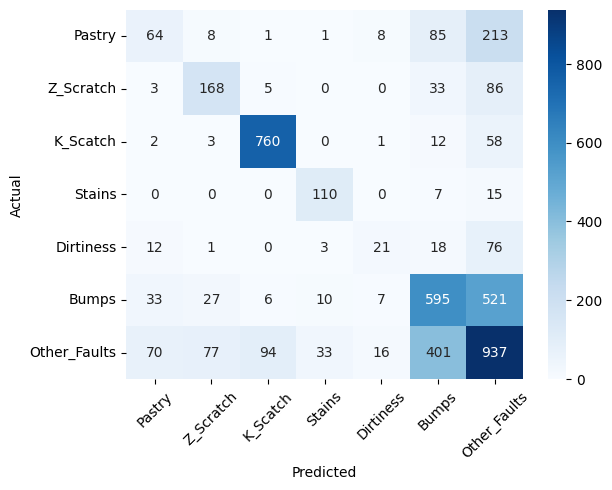

In [11]:
cm = pd.DataFrame(confusion_matrix(y_test,get_predictions(clf, X_test, False)), 
                  index=target_features, columns=target_features)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.ylabel('Actual')
plt.show()

In [12]:
def objective(trial: optuna.Trial) -> float:
    params = dict(
        tree_method='hist',
        objective='multi:softmax',
        eval_metric='roc_auc', 
        num_class=len(target_features), 
        iterations=100, 
        random_state=0,
        
        learning_rate= trial.suggest_float('learning_rate', 0.005, 0.05),
        n_estimators= trial.suggest_int('n_estimators',250,1000),
        reg_alpha=trial.suggest_float('reg_alpha', 1e-8, 10.0,log=True),
        reg_lambda=trial.suggest_float('reg_lambda', 1e-8, 10.0,log=True),
        max_depth=trial.suggest_int('max_depth', 3, 20),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.3, 1.0),
        subsample=trial.suggest_float('subsample', 0.5, 1.0),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 5)
    )

    clf, X_test, y_test = get_fitted_xgboost(params)
    predictions = clf.predict(X_test)

    return clf.score(X_test, y_test)

In [13]:
study = optuna.create_study(study_name='defect-detection', direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=False, n_jobs=-1)

best_study = study.best_trial

print('Trials completed:', len(study.trials))
print('Best value: ', best_study.value)
print('Best params: ', best_study.params)

Trials completed: 30
Best value:  0.5974788089545751
Best params:  {'learning_rate': 0.008839489367746691, 'n_estimators': 799, 'reg_alpha': 0.00102039158464648, 'reg_lambda': 0.0004388017695395069, 'max_depth': 13, 'colsample_bytree': 0.6604207067365462, 'subsample': 0.8839440644642192, 'min_child_weight': 3}


In [14]:
print('Parameter importances:')
print(optuna.importance.get_param_importances(study))

Parameter importances:
{'learning_rate': 0.41370301900142115, 'n_estimators': 0.2130819808119865, 'max_depth': 0.1369135705274998, 'subsample': 0.10185085650772611, 'min_child_weight': 0.07666017019590242, 'colsample_bytree': 0.034351962479060645, 'reg_lambda': 0.01936675041973249, 'reg_alpha': 0.0040716900566706606}


In [15]:
predictions = get_predictions(clf, X_test)
predictions.to_csv('submission.csv')
predictions.head()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,
10431,0.022556,0.000075,0.000067,0.000005,0.008476,0.805191,0.163629
10455,0.006590,0.000465,0.001011,0.000057,0.006249,0.296704,0.688924
16432,0.005334,0.325101,0.001355,0.000011,0.001660,0.330625,0.335913
6946,0.209052,0.010217,0.000179,0.000026,0.002353,0.289814,0.488359
16663,0.000460,0.000156,0.828380,0.000009,0.000046,0.000254,0.170695
